In [1]:
import os
import pandas as pd
import numpy as np
import scipy.stats as st
from sklearn.metrics.pairwise import pairwise_distances
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors

## Input data

In [2]:
celltype = "IGH_HUMAN"
myfiles = [x for x in os.listdir(".") if x.startswith('cdr3-clones') and celltype in x]
myfiles

['cdr3-clones-IgSub-IGH_HUMAN-after-reassignment.csv',
 'cdr3-clones-Vasculitis-IGH_HUMAN-after-reassignment.csv']

In [3]:
pt_file="20201116-RUN40-DataSheet.csv"
run = "run40"
plotfile=run + "-similarity-" + celltype + '.pdf'
suspects_list = run + "-similarity-" + celltype + ".txt"
excel_file = run + "-similarity-" + celltype + ".xlsx"
print("Outfile:", plotfile)

Outfile: run40-similarity-IGH_HUMAN.pdf


## Import clonesdata

In [4]:
clones = pd.read_csv(myfiles[0], sep="\t")
if len(myfiles) > 1:
    for clones_file in myfiles[1:]:
        clones = pd.concat([clones, pd.read_csv(clones_file, sep="\t")])

In [5]:
clones.head()

,Sample,MID,cdr3pep,freq,uniq_umis,V_sub,J_sub,sum_sites,avg_sites,read_perc,umi_perc
0,ID598t0-B2_S224,ACGTACGT,CAKGSTVVSLDDSWGQGTLVT,50,47,IGHV3-23,IGHJ5,1,0.020000,0.250476,0.252308
1,ID598t0-B2_S224,ACGTACGT,CARGTGTSWFDSWGQGTLVT,44,43,IGHV1-2,IGHJ5,1,0.022727,0.220419,0.230835
2,ID598t0-B2_S224,ACGTACGT,CARSILMGPSQPRHIDYWGQGILVT,38,38,IGHV3-21,IGHJ4,0,0.000000,0.190362,0.203994
3,ID598t0-B2_S224,ACGTACGT,CVRDFSWSFDQWGQGTLVT,28,26,IGHV3-48,"IGHJ5,IGHJ4",0,0.000000,0.140267,0.139575
4,ID598t0-B2_S224,ACGTACGT,CVGLGNYIYWGQGTLVT,22,21,IGHV3-13,IGHJ4,21,0.954545,0.110209,0.112734


In [6]:
# Summarize data on CDR3
clones = clones.groupby(by=['Sample','cdr3pep']).sum()
clones = clones.reset_index()
clones = clones.sort_values(['Sample','freq'], ascending=False)
clones.head()

,Sample,cdr3pep,freq,uniq_umis,sum_sites,avg_sites,read_perc,umi_perc
161947,VC023V2-SUB-U_S182,CAKGGDNEGWFDPWGQGTLVT,6680,175,74,0.011078,23.036071,11.075949
161912,VC023V2-SUB-U_S182,CAKETMEMSMPYWHFDLWGRGTQVT,3664,113,148,0.040393,12.635354,7.151899
162028,VC023V2-SUB-U_S182,CARDALVYASMWTGYFQHWGQGTLVT,3528,108,3512,0.995465,12.166356,6.835443
162177,VC023V2-SUB-U_S182,CVGGGGWDLAYWGHGTLVT,2279,94,12,0.005265,7.859163,5.949367
161996,VC023V2-SUB-U_S182,CAKVLRSYSTYYTMDVWGLGTTVT,1891,66,8,0.004231,6.521139,4.177215


## Import patient table

In [7]:
pt = pd.read_csv(pt_file, sep=",", skiprows=20)
pt = pt.rename(columns = {'Sample': 'SampleInfo'})
pt.head()

,Sample_ID,Sample_Name,Sample_Plate,Sample_Well,I7_Index_ID,index,I5_Index_ID,index2,Run,Nr,...,Species,Chain,Patient,SampleInfo,UMI,Group,HEK cells,RACE,Constant,ChainOrig
0,N711_S502,A11-Bh,NaN,NaN,NaN,NaN,NaN,NaN,NaN,S9,...,mouse,BCRh,A1,Spleen-day21,no,VERA,yes,no,no,mBCRh
1,N712_S502,A12-Bh,NaN,NaN,NaN,NaN,NaN,NaN,NaN,S10,...,mouse,BCRh,A2,Spleen-day21,no,VERA,yes,no,no,mBCRh
2,N714_S502,A13-Bh,NaN,NaN,NaN,NaN,NaN,NaN,NaN,S11,...,mouse,BCRh,A3,Spleen-day21,no,VERA,yes,no,no,mBCRh
3,N715_S502,A14-Bh,NaN,NaN,NaN,NaN,NaN,NaN,NaN,S12,...,mouse,BCRh,A4,Spleen-day21,no,VERA,yes,no,no,mBCRh
4,N716_S502,A15-Bh,NaN,NaN,NaN,NaN,NaN,NaN,NaN,S13,...,mouse,BCRh,A5,Spleen-day21,no,VERA,yes,no,no,mBCRh


In [8]:
# Concatenate sample-id and nr in a new column
f = lambda x,y: str(x) + "_" + str(y)
pt['Sample'] = [name for name in map(f, pt['Sample_Name'], pt['Nr'])]
pt = pt[["Sample","Patient"]]

In [9]:
pt.head()

,Sample,Patient
0,A11-Bh_S9,A1
1,A12-Bh_S10,A2
2,A13-Bh_S11,A3
3,A14-Bh_S12,A4
4,A15-Bh_S13,A5


## Merge clones with pt

In [10]:
# Join data frames
df = pd.merge(clones, pt, how='inner', on = 'Sample')
df.head()

,Sample,cdr3pep,freq,uniq_umis,sum_sites,avg_sites,read_perc,umi_perc,Patient
0,VC023V2-SUB-U_S182,CAKGGDNEGWFDPWGQGTLVT,6680,175,74,0.011078,23.036071,11.075949,VC023V2
1,VC023V2-SUB-U_S182,CAKETMEMSMPYWHFDLWGRGTQVT,3664,113,148,0.040393,12.635354,7.151899,VC023V2
2,VC023V2-SUB-U_S182,CARDALVYASMWTGYFQHWGQGTLVT,3528,108,3512,0.995465,12.166356,6.835443,VC023V2
3,VC023V2-SUB-U_S182,CVGGGGWDLAYWGHGTLVT,2279,94,12,0.005265,7.859163,5.949367,VC023V2
4,VC023V2-SUB-U_S182,CAKVLRSYSTYYTMDVWGLGTTVT,1891,66,8,0.004231,6.521139,4.177215,VC023V2


## Determine distance between samples

In [11]:
df_pivot = df.pivot_table(columns=['Patient','Sample'], index='cdr3pep', values='freq')
df_pivot = df_pivot.fillna(0)
df_pivot.head()

Patient                               A2                                   \
Sample                  VC008V3-2-B_S158 VC008V3-B_S157 VC008VV1-2-B_S156   
cdr3pep                                                                     
AAAGTTGASNADYWGQGTLVT                0.0            0.0               0.0   
AAYGSGKLYYYGMDVWGQGTTVT              0.0            0.0               0.0   
AFAENKWFGGHWIDPWGQGILVT              0.0            0.0               0.0   
AFAENKWFGGHWTDPWGQGILVT              0.0            0.0               0.0   
AFDIWGQGTMVT                         0.0            0.0               0.0   

Patient                          GPA161                                    \
Sample                  GPA161-2-B_S140 GPA161-2-SUB-U_S184 GPA161-B_S139   
cdr3pep                                                                     
AAAGTTGASNADYWGQGTLVT               0.0                 0.0           0.0   
AAYGSGKLYYYGMDVWGQGTTVT             0.0                 0.0           0.0   
AFAENKWFGGHWIDPWGQGILVT             0.0                 0.0           0.0   
AFAENKWFGGHWTDPWGQGILVT             0.0                 0.0           0.0   
AFDIWGQGTMVT                        0.0                 0.0           0.0   

Patient                                           ID598t0                  \
Sample                  GPA161-SUB-U_S183 ID598t0-B2_S224 ID598t0-B3_S228   
cdr3pep                                                                     
AAAGTTGASNADYWGQGTLVT                 0.0             0.0             0.0   
AAYGSGKLYYYGMDVWGQGTTVT               0.0             1.0             0.0   
AFAENKWFGGHWIDPWGQGILVT               0.0             0.0             0.0   
AFAENKWFGGHWTDPWGQGILVT               0.0             0.0             0.0   
AFDIWGQGTMVT                          0.0             0.0             0.0   

Patient                         ID629t0        ...                    VC008V4  \
Sample                  ID629t0-B2_S225        ...         VC008V4-SUB-U_S204   
cdr3pep                                        ...                              
AAAGTTGASNADYWGQGTLVT               4.0        ...                        0.0   
AAYGSGKLYYYGMDVWGQGTTVT             0.0        ...                        0.0   
AFAENKWFGGHWIDPWGQGILVT             6.0        ...                        0.0   
AFAENKWFGGHWTDPWGQGILVT             1.0        ...                        0.0   
AFDIWGQGTMVT                        0.0        ...                        0.0   

Patient                          VC008V5                                      \
Sample                  VC008V5-2-B_S162 VC008V5-2-SUB-U_S207 VC008V5-B_S161   
cdr3pep                                                                        
AAAGTTGASNADYWGQGTLVT                0.0                  0.0            0.0   
AAYGSGKLYYYGMDVWGQGTTVT              0.0                  0.0            0.0   
AFAENKWFGGHWIDPWGQGILVT              0.0                  0.0            0.0   
AFAENKWFGGHWTDPWGQGILVT              0.0                  0.0            0.0   
AFDIWGQGTMVT                         0.0                  0.0            0.0   

Patient                                                 VC008VV1  \
Sample                  VC008V5-SUB-U_S206 VC008VV1-2-SUB-U_S201   
cdr3pep                                                            
AAAGTTGASNADYWGQGTLVT                  0.0                   0.0   
AAYGSGKLYYYGMDVWGQGTTVT                0.0                   0.0   
AFAENKWFGGHWIDPWGQGILVT                0.0                   0.0   
AFAENKWFGGHWTDPWGQGILVT                0.0                   0.0   
AFDIWGQGTMVT                           0.0                   0.0   

Patient                                                            VC023V2  \
Sample                  VC008VV1-B_S141 VC008VV1-SUB-U_S185 VC023V2-B_S138   
cdr3pep                                                                      
AAAGTTGASNADYWGQGTLVT               0.0                 0.0            0.0   
AA

In [12]:
sim = 1 - pairwise_distances(df_pivot.T, metric = "braycurtis")
sim = pd.DataFrame(sim, index=df_pivot.columns, columns=df_pivot.columns)
sim.head()

Patient                                   A2                                   \
Sample                      VC008V3-2-B_S158 VC008V3-B_S157 VC008VV1-2-B_S156   
Patient Sample                                                                  
A2      VC008V3-2-B_S158            1.000000       0.109216          0.000162   
        VC008V3-B_S157              0.109216       1.000000          0.000000   
        VC008VV1-2-B_S156           0.000162       0.000000          1.000000   
GPA161  GPA161-2-B_S140             0.001467       0.000000          0.000100   
        GPA161-2-SUB-U_S184         0.000000       0.000000          0.000430   

Patient                              GPA161                                    \
Sample                      GPA161-2-B_S140 GPA161-2-SUB-U_S184 GPA161-B_S139   
Patient Sample                                                                  
A2      VC008V3-2-B_S158           0.001467            0.000000      0.000108   
        VC008V3-B_S157             0.000000            0.000000      0.000439   
        VC008VV1-2-B_S156          0.000100            0.000430      0.000819   
GPA161  GPA161-2-B_S140            1.000000            0.086724      0.032689   
        GPA161-2-SUB-U_S184        0.086724            1.000000      0.031206   

Patient                                               ID598t0                  \
Sample                      GPA161-SUB-U_S183 ID598t0-B2_S224 ID598t0-B3_S228   
Patient Sample                                                                  
A2      VC008V3-2-B_S158             0.000000        0.000000        0.000000   
        VC008V3-B_S157               0.000000        0.000000        0.000000   
        VC008VV1-2-B_S156            0.002291        0.000000        0.000000   
GPA161  GPA161-2-B_S140              0.007856        0.000063        0.000145   
        GPA161-2-SUB-U_S184          0.065968        0.000000        0.000000   

Patient                             ID629t0        ...          \
Sample                      ID629t0-B2_S225        ...           
Patient Sample                                     ...           
A2      VC008V3-2-B_S158           0.000109        ...           
        VC008V3-B_S157             0.000000        ...           
        VC008VV1-2-B_S156          0.000000        ...           
GPA161  GPA161-2-B_S140            0.000085        ...           
        GPA161-2-SUB-U_S184        0.000000        ...           

Patient                                VC008V4          VC008V5  \
Sample                      VC008V4-SUB-U_S204 VC008V5-2-B_S162   
Patient Sample                                                    
A2      VC008V3-2-B_S158              0.000000         0.000019   
        VC008V3-B_S157                0.001925         0.000000   
        VC008VV1-2-B_S156             0.000000         0.000000   
GPA161  GPA161-2-B_S140               0.000000         0.002079   
        GPA161-2-SUB-U_S184           0.000319         0.000018   

Patient                                                          \
Sample                      VC008V5-2-SUB-U_S207 VC008V5-B_S161   
Patient Sample                                                    
A2      VC008V3-2-B_S158                0.000000       0.001726   
        VC008V3-B_S157                  0.000000       0.000000   
        VC008VV1-2-B_S156               0.000000       0.001033   
GPA161  GPA161-2-B_S140                 0.000272       0.001538   
        GPA161-2-SUB-U_S184             0.000240       0.000470   

Patient                                                     VC008VV1  \
Sample                      VC008V5-SUB-U_S206 VC008VV1-2-SUB-U_S201   
Patient Sample                                                         
A2      VC008V3-2-B_S158              0.000000              0.000000   
        VC008V3-B_S157                0.000000              0.000000   
        VC008VV1-2-B_S156             0.001474              0.024609   
GPA161  GPA161-2-B

In [13]:
sim.to_excel(excel_file)
print("Wrote", excel_file, "to disk")

Wrote run40-similarity-IGH_HUMAN.xlsx to disk


## Create a heatmap

In [14]:
def drawBox(end, length):
    '''
    Description: draw a square with lines
    In: start (int), length (int)
    Out: None, 4 lines will be drawn on the canvas
    '''
    linewidth = 5
    low = end - length
    high = end
    plt.plot([low, high], [high, high], 'k-', lw=linewidth)   # N
    plt.plot([high, high], [low, high], 'k-', lw=linewidth)   # E
    plt.plot([low, high], [low, low], 'k-', lw=linewidth)     # S
    plt.plot([low, low], [low, high], 'k-', lw=linewidth)     # W

In [15]:
def drawHeatmap(overlap):
    font = {'family' : 'sans-serif',
            'weight' : 'normal',
            'size'   : 22}

    matplotlib.rc('font', **font)

    fig, ax = plt.subplots(figsize=(60, 60))
    fig.subplots_adjust(bottom=0.3)

    # is used for log scaling
    Z1 = overlap.values
    Z1[Z1 <= 0] = Z1[Z1 > 0].min()  # Replace any value below or equal to zero with lowest value above zero
    
    print("min value:", Z1.min())
    print("max value:", Z1.max())

    # get the patient-id
    labels_x = [x[0] for x in overlap.index]
    labels_y = [y[0] for y in overlap.columns]

    # draw heatmap
    plt.pcolor(overlap.values, cmap=plt.cm.viridis, norm=colors.LogNorm(vmin=Z1.min(), vmax=Z1.max()))
    #plt.pcolor(overlap.values, cmap=plt.cm.viridis)
    plt.colorbar()
    plt.yticks(np.arange(0.5, len(overlap.index), 1), overlap.columns, rotation=0)
    plt.xticks(np.arange(0.5, len(overlap.columns), 1), overlap.index, rotation=90)

    # Add lines around same patient-id
    prev_label = None
    length = 0
    for i in range(len(labels_x)):
        if prev_label is not None and prev_label != labels_x[i]:
            drawBox(i, length)
            length = 0
        prev_label = labels_x[i]
        length +=1
    i += 1
    drawBox(i, length)

    # Save figure to file
    fig.savefig(plotfile)
    print("Wrote", plotfile, "to disk")

min value: 1.051392043061039e-05
max value: 1.0
Wrote run40-similarity-IGH_HUMAN.pdf to disk


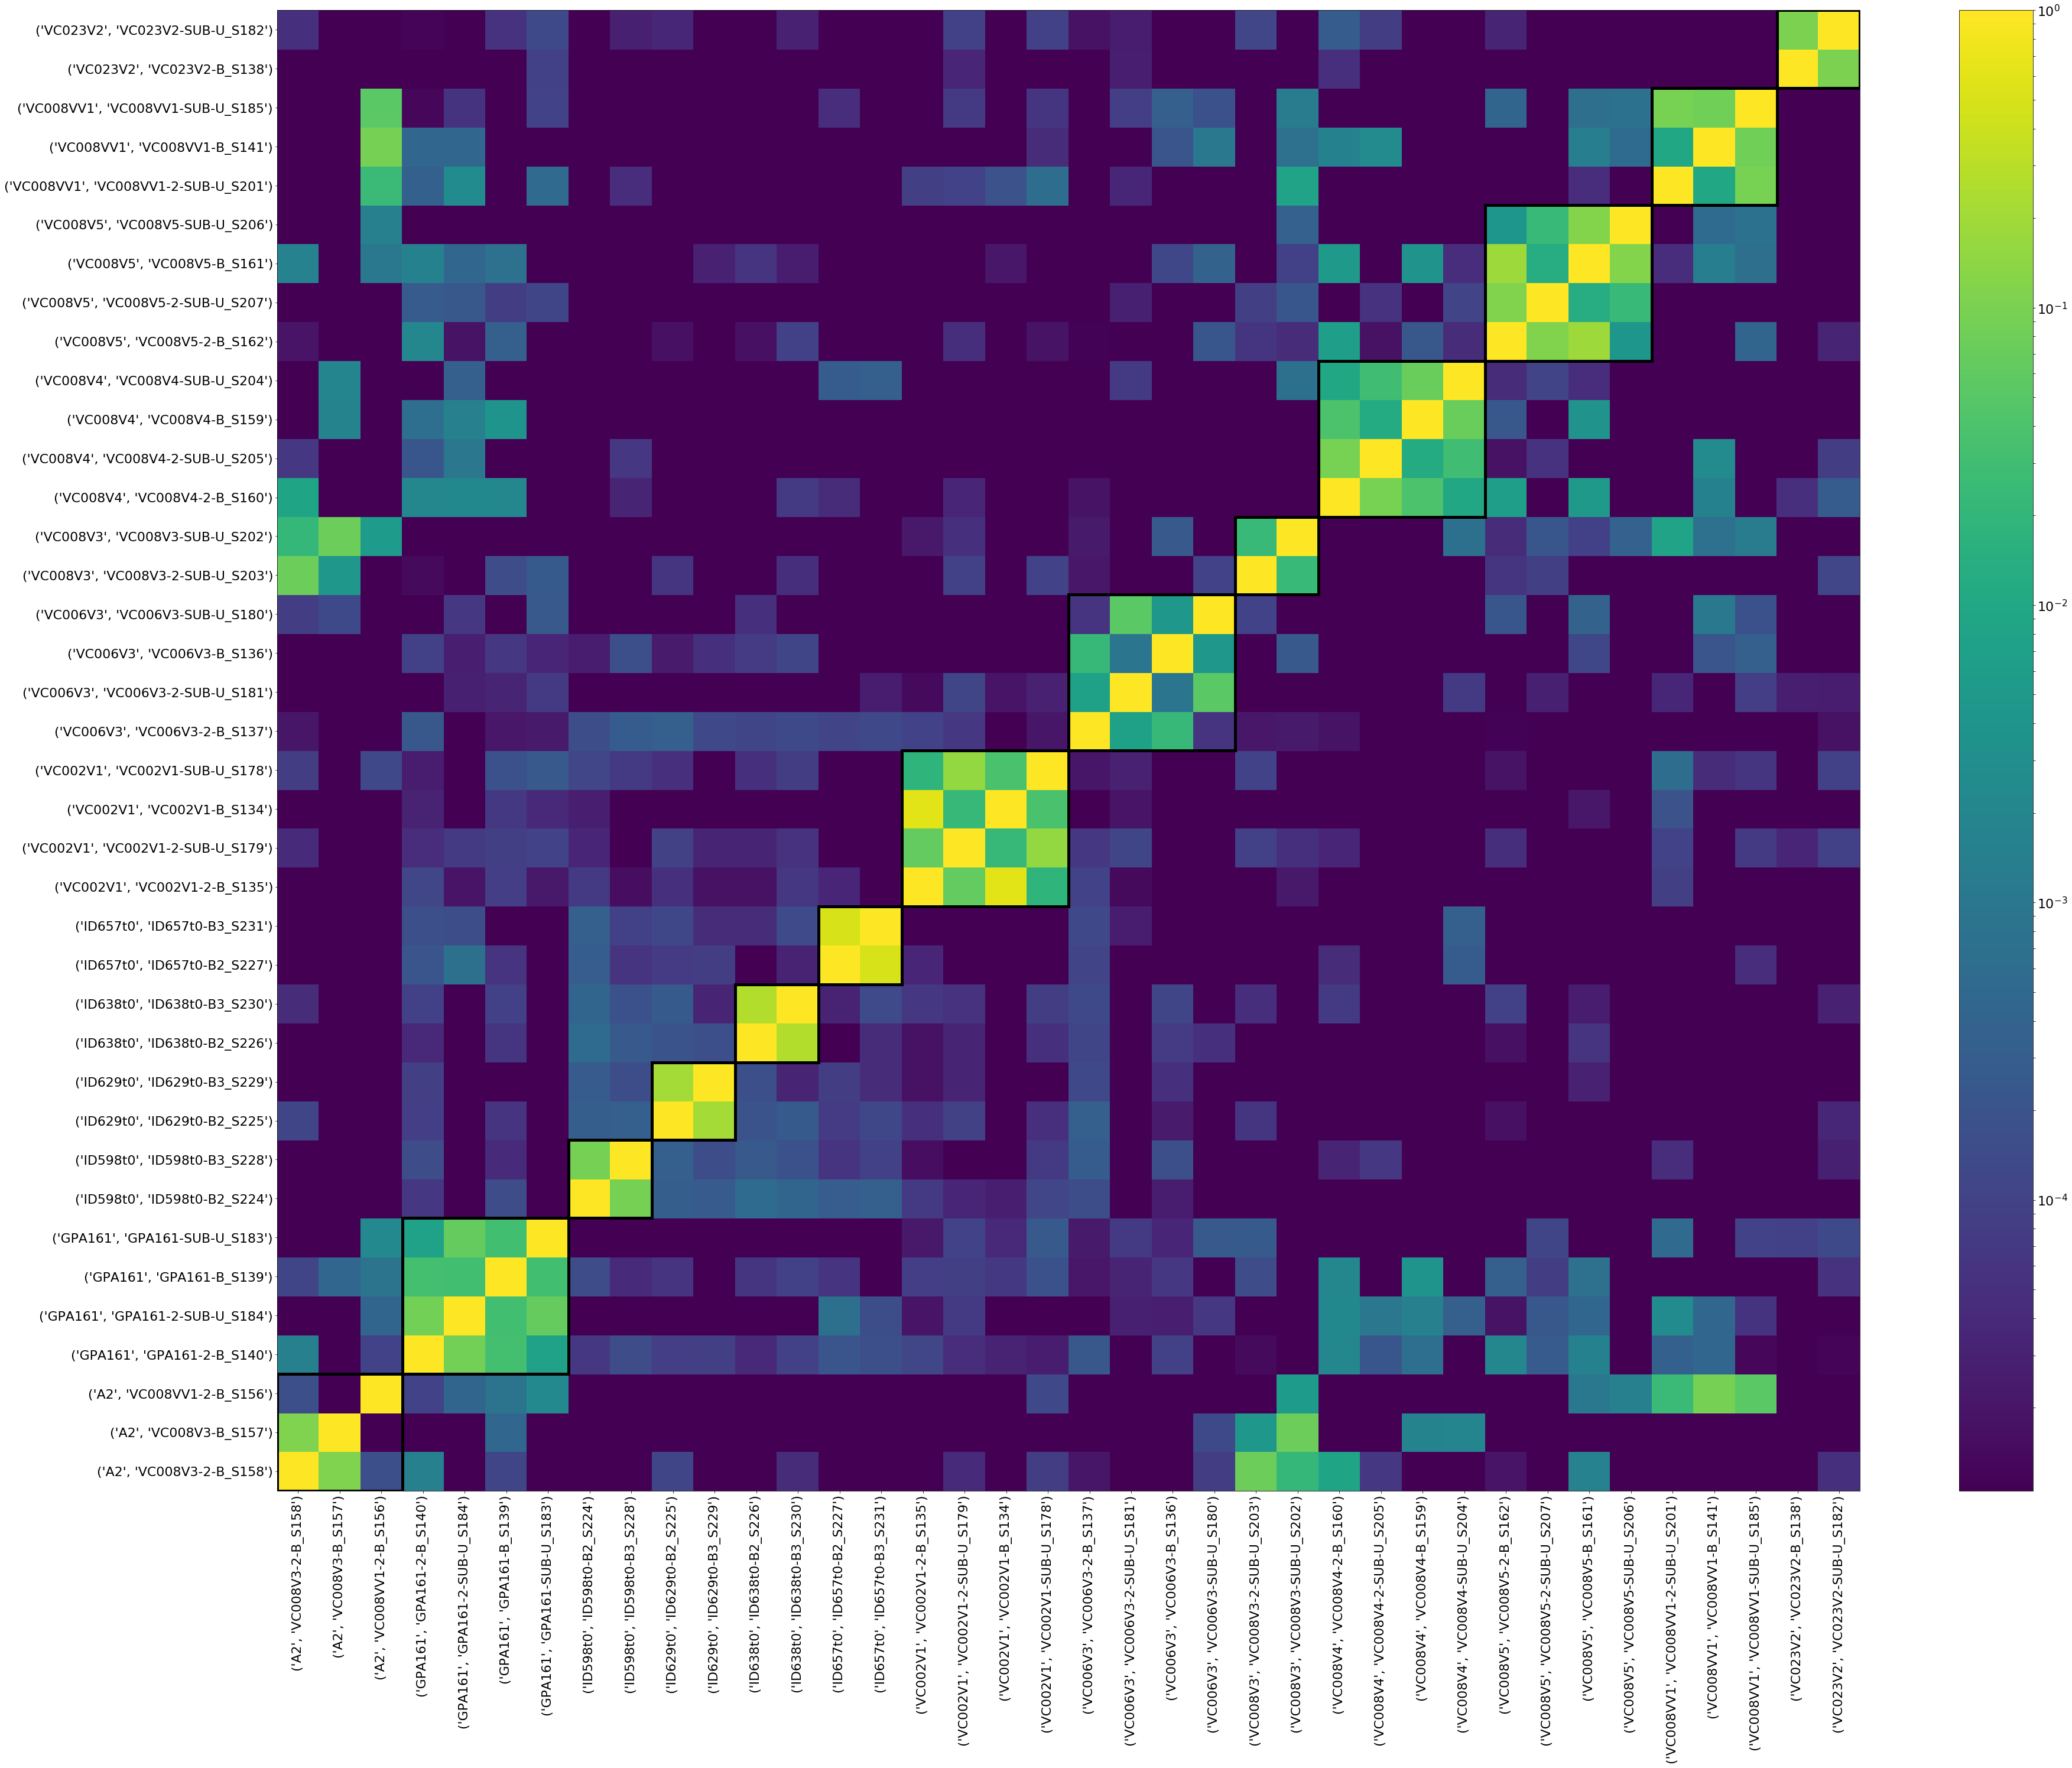

In [16]:
drawHeatmap(sim)

## Highlight anomalies

In [17]:
# get index pairs of same patient (divide same vs not same sample) and list indices for different patients
same_sample = list()
same_patient = list()
diff_patient = list()
for x in sim.index:
    for y in sim.columns:
        if x[0] == y[0]:  # same patient
            if x[1] == y[1]:  # same sample
                same_sample.append((x, y))
            else:        # same patient, but not same sample
                same_patient.append((x, y))
        else:             # not same patient
            diff_patient.append((x,y))                    

In [18]:
# Get values of same patient (but different samples) and values for different patients
values_same_patient = [sim.loc[x][y] for x,y in same_patient]
values_diff_patient = [sim.loc[x][y] for x,y in diff_patient]
mean_diff_patient = np.mean(values_diff_patient)
std_diff_patient = np.std(values_diff_patient)
threshold = mean_diff_patient + 4 * std_diff_patient
print("mean same patient", np.mean(values_same_patient), np.std(values_same_patient))
print("mean diff patient", mean_diff_patient, std_diff_patient)
print("threshold", threshold)

mean same patient 0.08172414505741107 0.11971273666352306
mean diff patient 0.0006922408186077551 0.00598577777957303
threshold 0.024635351936899873


{'whiskers': [<matplotlib.lines.Line2D at 0x7f067767e0f0>,
 'caps': [<matplotlib.lines.Line2D at 0x7f067767e9b0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f067767ff60>,
 'medians': [<matplotlib.lines.Line2D at 0x7f0677643240>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f0677643668>,
 'means': []}

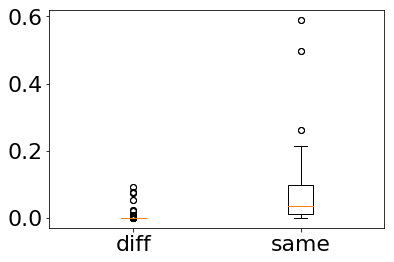

In [19]:
# Boxplot
plt.boxplot([values_diff_patient, values_same_patient], labels=['diff', 'same'])

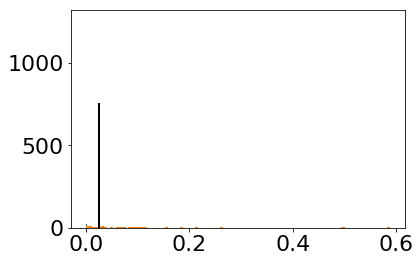

In [20]:
# Histogram
plt.hist(values_diff_patient, bins=100)
plt.hist(values_same_patient, bins=100)
plt.plot([threshold, threshold], [0, 750], 'k-', lw=2)

In [21]:
# Print sample names if similarity is twice the 95% interval
fhOut = open(suspects_list, "w")
check_samples = list()
for i,j in diff_patient:
    if sim.loc[i][j] > threshold:
        print(i, j, sim.loc[i][j])
        print(i, j, sim.loc[i][j], file=fhOut)
        check_samples.append((i,j))
fhOut.close()
print("Wrote", suspects_list, "to disk")

('A2', 'VC008V3-2-B_S158') ('VC008V3', 'VC008V3-2-SUB-U_S203') 0.07669831994156318
('A2', 'VC008V3-B_S157') ('VC008V3', 'VC008V3-SUB-U_S202') 0.07543323139653413
('A2', 'VC008VV1-2-B_S156') ('VC008VV1', 'VC008VV1-B_S141') 0.0908472973372344
('A2', 'VC008VV1-2-B_S156') ('VC008VV1', 'VC008VV1-SUB-U_S185') 0.05232789494627932
('VC008V3', 'VC008V3-2-SUB-U_S203') ('A2', 'VC008V3-2-B_S158') 0.07669831994156318
('VC008V3', 'VC008V3-SUB-U_S202') ('A2', 'VC008V3-B_S157') 0.07543323139653413
('VC008VV1', 'VC008VV1-B_S141') ('A2', 'VC008VV1-2-B_S156') 0.0908472973372344
('VC008VV1', 'VC008VV1-SUB-U_S185') ('A2', 'VC008VV1-2-B_S156') 0.05232789494627932
Wrote run40-similarity-IGH_HUMAN.txt to disk


In [22]:
sim2 = sim.copy()
for i, j in check_samples:
    sim2.loc[i][j] = 1

min value: 1.051392043061039e-05
max value: 1.0
Wrote run40-similarity-IGH_HUMAN-highlighted.pdf to disk


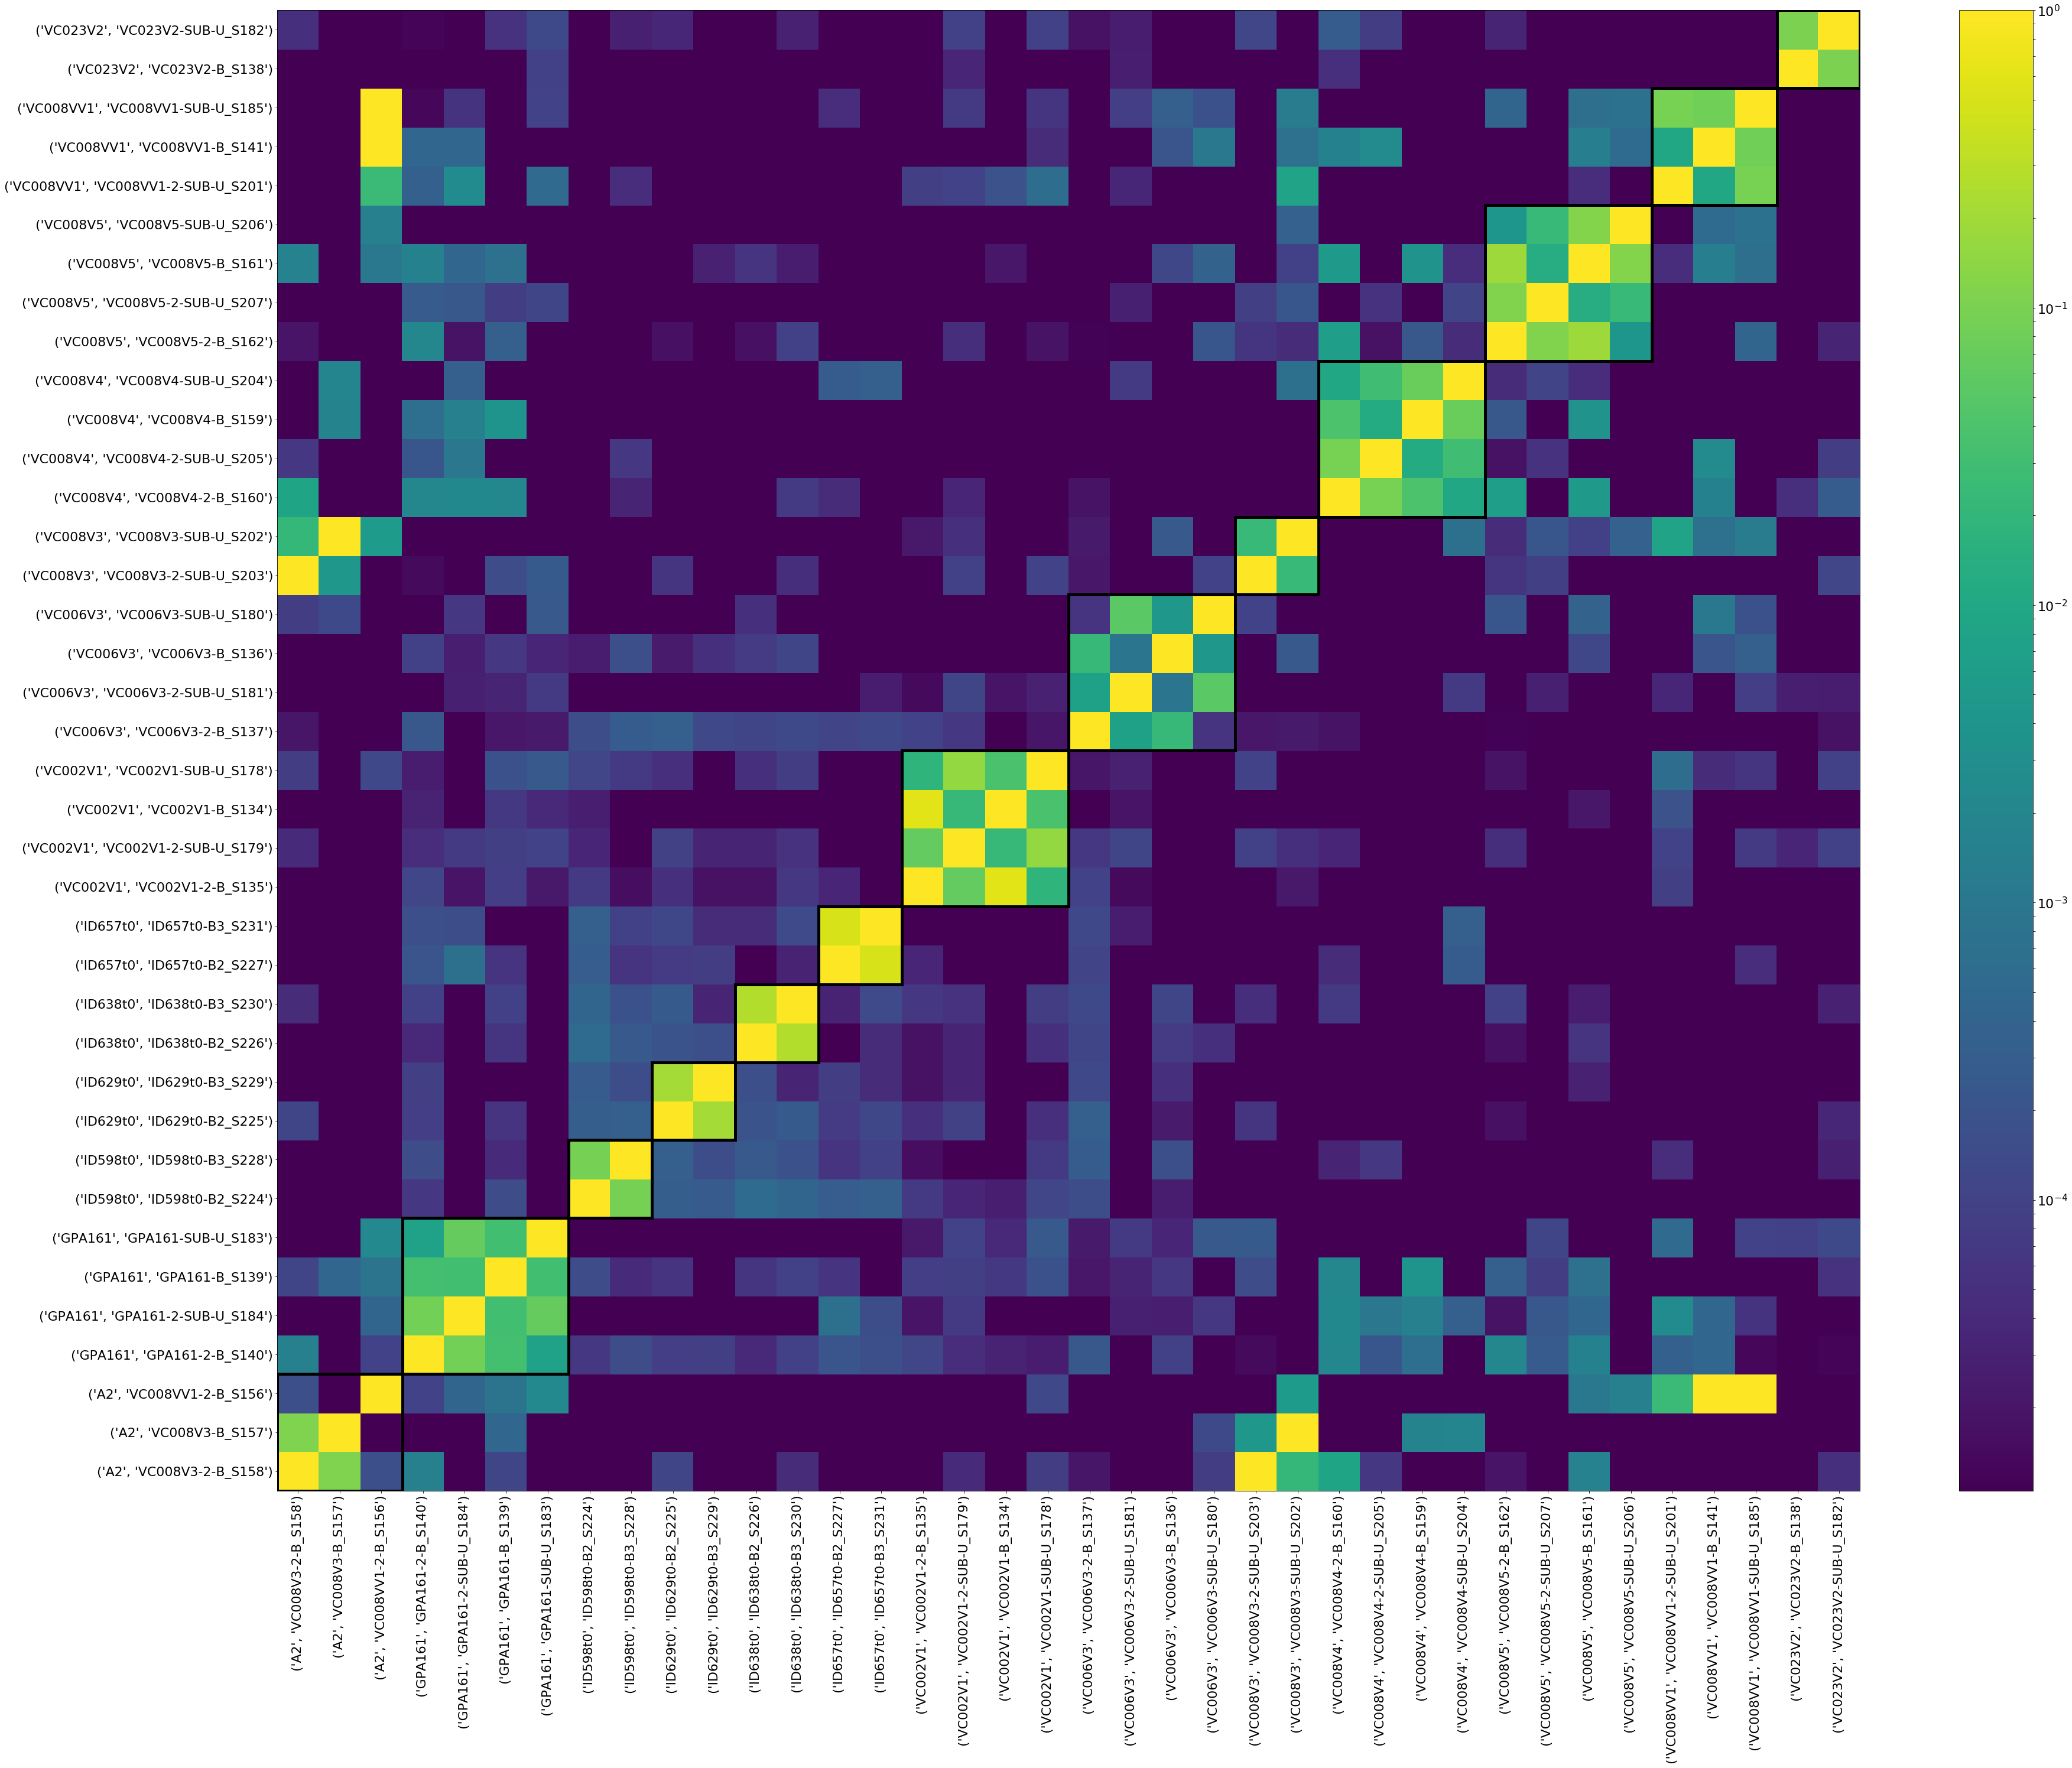

In [23]:
plotfile = plotfile.replace('.pdf', '-highlighted.pdf')
drawHeatmap(sim2)